In [33]:
%matplotlib inline

import glob
import os


from IPython.core.display import Image
from bx.bbi.bigwig_file import BigWigFile 
import gffutils
import pandas as pd
import pysam

import pandas as pd
from IPython.core.display import HTML
import pybedtools
from gscripts.general import parsers

from clipper.src import get_genomic_regions
from gscripts.general import dataviz
import HTSeq
from gscripts.riboseq import riboseq_utils

img_dir = "."

In [10]:
combined_df = parsers.rnaseq_metrics("/home/gpratt/projects/encode_riboseq/analysis/encode_riboseq_v1/", num_seps=2)


In [11]:
HTML(combined_df[['Input Reads', 
                  "Reads Passing Quality Filter",
                  'Uniquely Mapped Reads', 
                  '% of reads unmapped: too short', 
                  #'percent_repetative',
                  #'percent_mapped',
                  ]].to_html(formatters={"Input Reads" : parsers.commas,
                                         "Reads Passing Quality Filter": parsers.commas,
                             "Uniquely Mapped Reads" : parsers.commas,
                             "Usable Reads" : parsers.commas,
                             "Num Peaks": parsers.commas,
                             "Trimmed reads" : parsers.commas,
                             "Processed reads" : parsers.commas,
                             "Too short reads" : parsers.commas,
                             #"percent_repetative" :  parsers.percent,
                             #"percent_mapped" : parsers.percent,
                             }))

,Input Reads,Reads Passing Quality Filter,Uniquely Mapped Reads,% of reads unmapped: too short
HS002-SR-R00204_AC8JDFACXX.RHK069-ATTACTCG_S4_L001_R1,"17,645,831","17,552,133","4,057,283",62.96%
HS002-SR-R00204_AC8JDFACXX.RHK070-TCCGGAGA_S5_L001_R1,"17,394,932","17,319,979","4,063,049",64.59%


In [8]:
combined_df = parsers.rnaseq_metrics("/home/gpratt/projects/encode_riboseq/analysis/encode_rnaseq_v1/", num_seps=2)


In [9]:
HTML(combined_df[['Input Reads', 
                  "Reads Passing Quality Filter",
                  'Uniquely Mapped Reads', 
                  '% of reads unmapped: too short', 
                  #'percent_repetative',
                  #'percent_mapped',
                  ]].to_html(formatters={"Input Reads" : parsers.commas,
                                         "Reads Passing Quality Filter": parsers.commas,
                             "Uniquely Mapped Reads" : parsers.commas,
                             "Usable Reads" : parsers.commas,
                             "Num Peaks": parsers.commas,
                             "Trimmed reads" : parsers.commas,
                             "Processed reads" : parsers.commas,
                             "Too short reads" : parsers.commas,
                             #"percent_repetative" :  parsers.percent,
                             #"percent_mapped" : parsers.percent,
                             }))

,Input Reads,Reads Passing Quality Filter,Uniquely Mapped Reads,% of reads unmapped: too short
HS002-SR-R00204_AC8JDFACXX.RHK066-GAGATTCC_S1_L001_R1,"1,556,096","999,423","111,959",85.25%
HS002-SR-R00204_AC8JDFACXX.RHK067-ATTCAGAA_S2_L001_R1,"1,447,992","942,752","117,563",84.01%
HS002-SR-R00204_AC8JDFACXX.RHK068-GAATTCGT_S3_L001_R1,"1,528,742","930,221","145,019",80.58%


#RPF Plotting

In [12]:
def get_five_prime_end(interval):
    #interval.score = str(len(interval)) 
    interval.score = str(sum(map(int, interval[10].split(","))))
    if interval.strand == "+":
        interval.stop = interval.start + 1
    else:
        interval.start = interval.stop - 1
    return interval

In [13]:
half_window_width = 50
def pad(interval):
    interval.start = interval.start - half_window_width 
    interval.stop = interval.stop + half_window_width
    return interval

In [18]:
features  = get_genomic_regions.GenomicFeatures( "hg19", 
                                                gffutils.FeatureDB("/projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db"),
                                                )
regions = features.get_feature_locations()
padded_start_codons = regions['start_codons'].each(pad).sort().saveas()
padded_stop_codons = regions['stop_codons'].each(pad).sort().saveas()

In [22]:
files = glob.glob("/home/gpratt/projects/encode_riboseq/analysis/encode_riboseq_v1/*.rg.bam")
riboseq = {".".join(os.path.basename(name).split(".")[:2]): pybedtools.BedTool(name) for name in files }

In [25]:
%load_ext autoreload 
%autoreload 2

reload(riboseq_utils)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'gscripts.riboseq.riboseq_utils' from '/home/gpratt/gscripts/gscripts/riboseq/riboseq_utils.pyc'>

In [29]:
stop_distance_results = {}
for experiment in riboseq:
    print "starting ", experiment, 
    stop_distance_results[experiment] = riboseq_utils.get_closest(riboseq[experiment], regions['stop_codons']).T
    print "done!"

 starting  HS002-SR-R00204_AC8JDFACXX.RHK070-TCCGGAGA_S5_L001_R1 done!
starting  HS002-SR-R00204_AC8JDFACXX.RHK069-ATTACTCG_S4_L001_R1 done!


In [30]:
distance_results = {}
for experiment in riboseq:
    print "starting ", experiment, 
    distance_results[experiment] = riboseq_utils.get_closest(riboseq[experiment], regions['start_codons']).T
    print "done!"

starting  HS002-SR-R00204_AC8JDFACXX.RHK070-TCCGGAGA_S5_L001_R1 done!
starting  HS002-SR-R00204_AC8JDFACXX.RHK069-ATTACTCG_S4_L001_R1 done!


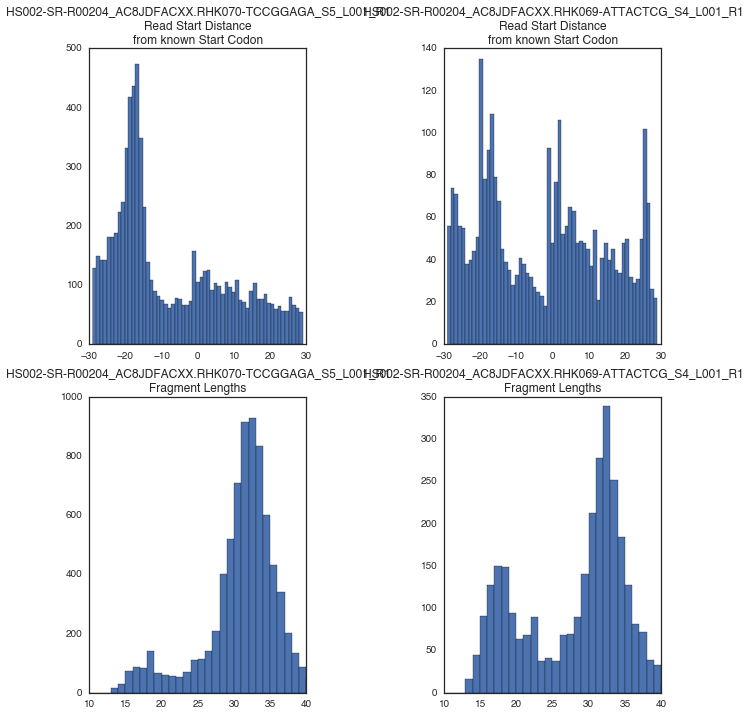

In [35]:
#fig = plt.Figure()
with dataviz.Figure(os.path.join(img_dir, "ribosome_occupancy_cdf_start_site.svg"), figsize=(10,10)) as fig:
    for count, (name, closest_start_df) in enumerate(distance_results.items()):
        closest_start_df_filtered = closest_start_df[(closest_start_df.dist > -30) & (closest_start_df.dist < 30) ]

        ax = fig.add_subplot(2, len(distance_results.items()), count + 1)
        x = ax.hist(closest_start_df_filtered.dist, bins=59)
        ax.set_title("_".join(name.split("_")) + "\nRead Start Distance\nfrom known Start Codon")
        
        ax = fig.add_subplot(2, len(distance_results.items()), len(distance_results.items()) + count + 1)
        x = ax.hist(closest_start_df_filtered.length, bins=100, range=(0,100))
        ax.set_xlim(10,40)
        ax.set_title("_".join(name.split("_"))  + "\nFragment Lengths")

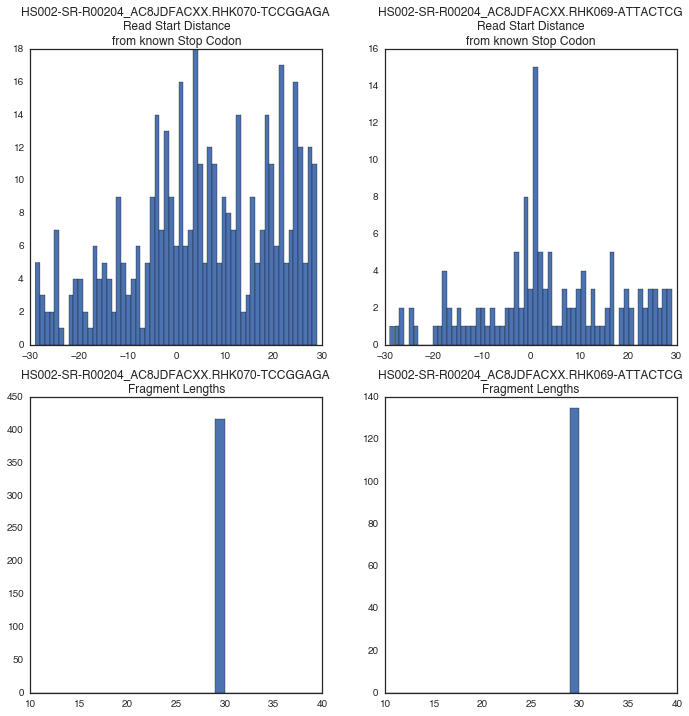

In [37]:
with dataviz.Figure(os.path.join(img_dir, "ribosome_occupancy_cdf_stop_site.svg"), figsize=(10,10)) as fig:
    for count, (name, closest_stop_df) in enumerate(stop_distance_results.items()):
        closest_stop_df_filtered = closest_stop_df[(closest_stop_df.dist > -30) & (closest_stop_df.dist < 30) & (closest_stop_df.length == 29) ]

        ax = fig.add_subplot(2, len(stop_distance_results.items()), count + 1)
        x = ax.hist(closest_stop_df_filtered.dist, bins=59)
        ax.set_title("_".join(name.split("_")[:2]) + "\nRead Start Distance\nfrom known Stop Codon")
        
        ax = fig.add_subplot(2, len(stop_distance_results.items()), len(stop_distance_results.items()) + 1+ count)
        x = ax.hist(closest_stop_df_filtered.length, bins=100, range=(0,100))
        ax.set_xlim(10,40)
        ax.set_title("_".join(name.split("_")[:2]) + "\nFragment Lengths")